In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import calendar
from pandas.plotting import lag_plot
from scipy import interpolate
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
import statsmodels.graphics.tsaplots as tsa_plots
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from prophet import Prophet
from statsmodels.tools.eval_measures import rmse
from prophet.plot import plot_components_plotly,plot_plotly
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,ExponentialSmoothing
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler

In [ ]:
oil = pd.read_excel("Crude_Oil_Prices_Daily.xlsx")

In [ ]:
oil.head()

Date  Closing Value
0 1986-01-02          25.56
1 1986-01-03          26.00
2 1986-01-06          26.53
3 1986-01-07          25.85
4 1986-01-08          25.87

In [ ]:
oil.tail()

Date  Closing Value
9559 2023-10-02          88.47
9560 2023-10-03          89.39
9561 2023-10-04          84.37
9562 2023-10-05          82.89
9563 2023-10-06          82.79

In [ ]:
oil.shape

(9564, 2)

In [ ]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9564 non-null   datetime64[ns]
 1   Closing Value  9557 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 149.6 KB


In [ ]:
oil.isnull().sum()

Date             0
Closing Value    7
dtype: int64

In [ ]:
oil[oil.isnull().any(axis=1)]

Date  Closing Value
8060 2017-11-23            NaN
8082 2017-12-25            NaN
8087 2018-01-01            NaN
8097 2018-01-15            NaN
8122 2018-02-19            NaN
8151 2018-03-30            NaN
8219 2018-07-04            NaN

In [ ]:
#dropping

oil = oil.dropna().reset_index(drop=True)

In [ ]:
oil.isnull().sum()

Date             0
Closing Value    0
dtype: int64

In [ ]:
#duplicate values
oil.duplicated().sum()

0

In [ ]:
oil.describe()

Closing Value
count    9557.000000
mean       46.789439
std        29.615017
min        10.250000
25%        20.090000
50%        37.700000
75%        69.380000
max       145.310000

In [ ]:
dt = pd.to_datetime("02/01/1996", format = "%d/%m/%Y")
dt1 = pd.to_datetime("06/10/2023", format = "%d/%m/%Y")

In [ ]:
print((dt1-dt).days)

10139


In [ ]:
oil.dtypes

Date             datetime64[ns]
Closing Value           float64
dtype: object

<Axes: xlabel='Closing Value'>

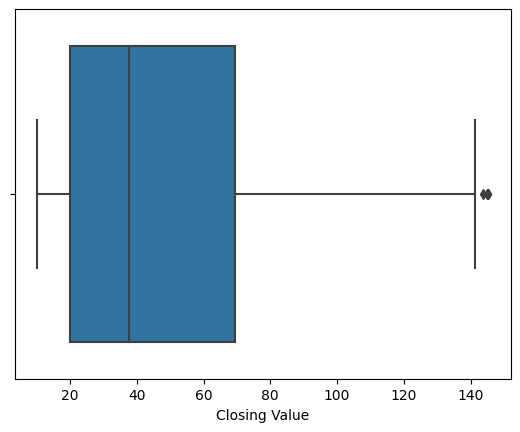

In [ ]:
sns.boxplot(x = "Closing Value", data = oil)

In [ ]:
Outliers = oil[oil["Closing Value"]>140]
Outliers

Date  Closing Value
5676 2008-07-01         141.06
5677 2008-07-02         143.74
5678 2008-07-03         145.31
5679 2008-07-07         141.38
5682 2008-07-10         141.47
5683 2008-07-11         144.96
5684 2008-07-14         145.16

In [ ]:
ClosingValue = oil["Closing Value"]

q1 = ClosingValue.quantile(0.25)
q3 = ClosingValue.quantile(0.75)
iqr = q3-q1

lower_bound = q1-1.5*iqr
upper_bound = q3+1.5*iqr

ClosingValue=np.where(ClosingValue<lower_bound,lower_bound,ClosingValue)
ClosingValue=np.where(ClosingValue>upper_bound,upper_bound,ClosingValue)

print("upper_bound",upper_bound)
print("lower_bound",lower_bound)

oil["Closing Value"] = ClosingValue


upper_bound 143.315
lower_bound -53.844999999999985


<Axes: xlabel='Closing Value'>

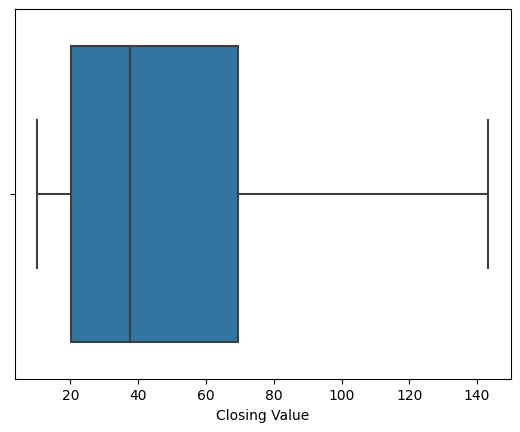

In [ ]:
sns.boxplot(x=oil["Closing Value"])

data visalization

In [ ]:
#lineplot
fig = px.line(data_frame=oil,x="Date", y="Closing Value", title = "CrudePrices", width=800,height=400)
fig.update_xaxes(title_text = "Date")
fig.update_yaxes(title_text = "Closing Values")
fig.show()


In [ ]:
oil.rename(columns={"Closing Value":"ClosingValue"},inplace=True)

In [ ]:
oil_new =oil.copy()
oil_new["Month"] = oil_new.Date.dt.month_name()
oil_new["year"] = oil_new.Date.dt.strftime("%Y")
oil_new["Week"] = oil_new.Date.dt.week

In [ ]:
oil_new.head()

Date  ClosingValue    Month  year  Week
0 1986-01-02         25.56  January  1986     1
1 1986-01-03         26.00  January  1986     1
2 1986-01-06         26.53  January  1986     2
3 1986-01-07         25.85  January  1986     2
4 1986-01-08         25.87  January  1986     2

In [ ]:
Month = calendar.month_name[1:]
oil_pivot = pd.pivot_table(data=oil_new,values="ClosingValue",index="year",columns="Month",aggfunc="mean",fill_value=0)
oil_pivot = oil_pivot.reindex(columns=Month)

In [ ]:
oil_pivot.round(2).head

<bound method NDFrame.head of Month  January  February   March   April     May    June    July  August  \
year                                                                       
1986     22.93     15.45   12.61   12.84   15.38   13.43   11.58   15.10   
1987     18.65     17.75   18.30   18.68   19.44   20.07   21.34   20.31   
1988     17.13     16.80   16.20   17.86   17.42   16.53   15.50   15.52   
1989     18.02     17.94   19.48   21.07   20.12   20.05   19.78   18.58   
1990     22.86     22.11   20.39   18.43   18.20   16.70   18.45   27.31   
1991     25.23     20.48   19.90   20.83   21.23   20.19   21.40   21.69   
1992     18.79     19.01   18.92   20.23   20.98   22.38   21.78   21.34   
1993     19.03     20.09   20.32   20.25   19.95   19.09   17.89   18.01   
1994     15.03     14.78   14.68   16.42   17.89   19.06   19.65   18.38   
1995     18.04     18.57   18.54   19.90   19.74   18.45   17.33   18.02   
1996     18.85     19.09   21.33   23.50   21.17   20.42  

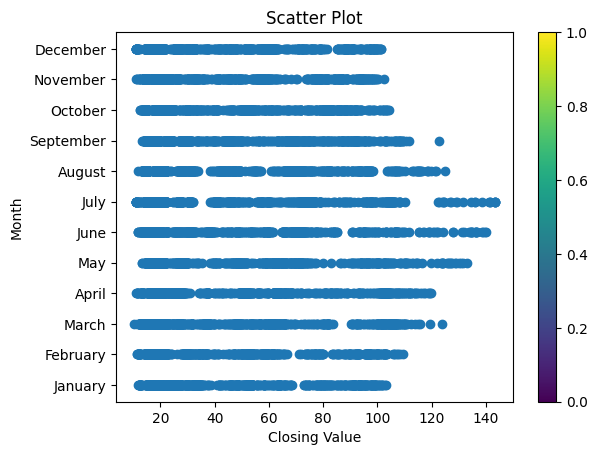

In [ ]:
#scatterplot
plt.scatter(oil['ClosingValue'],oil_new['Month'])
plt.title("Scatter Plot")
plt.xlabel("Closing Value")
plt.ylabel("Month")
plt.colorbar()
plt.show()

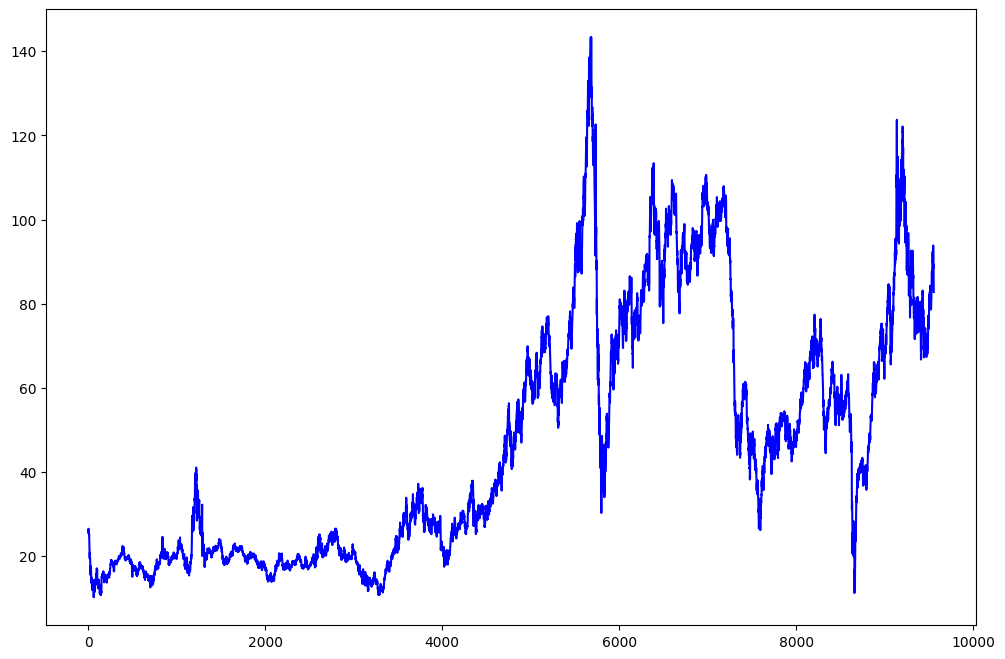

In [ ]:
oil_new["ClosingValue"].plot(figsize=(12,8), color="blue")
plt.show()

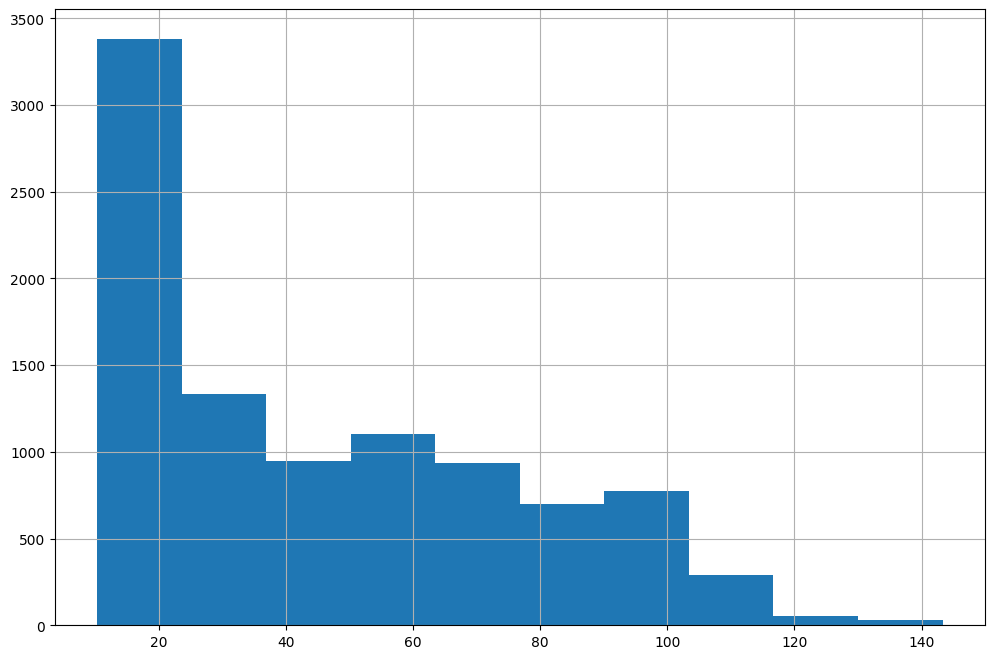

In [ ]:
oil_new.ClosingValue.hist(figsize=(12,8))
plt.show()

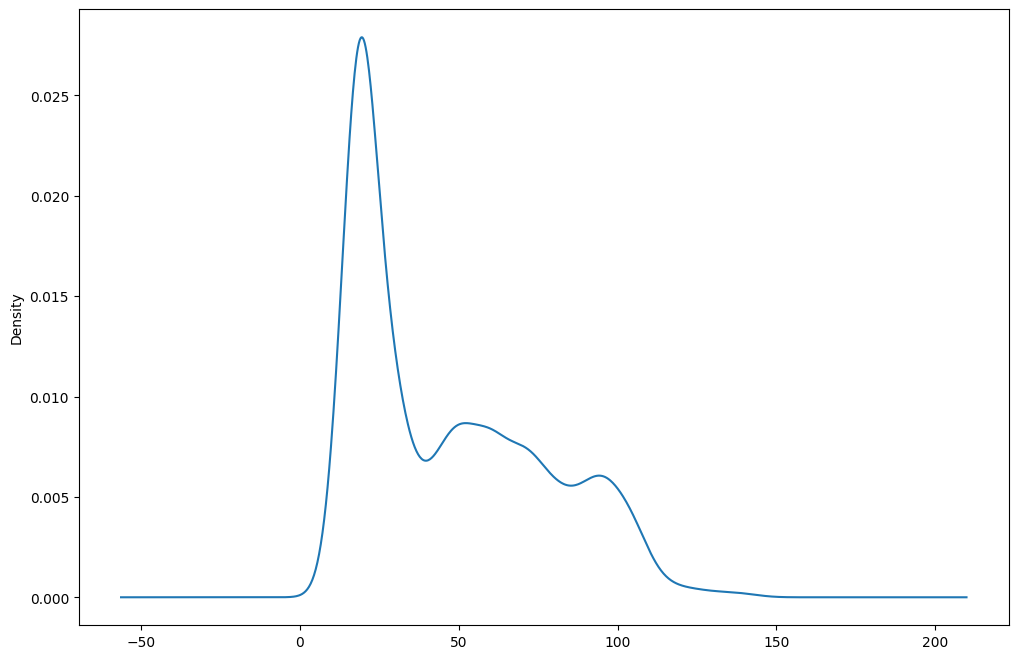

In [ ]:
oil.ClosingValue.plot(kind="kde",figsize=(12,8))
plt.show()

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

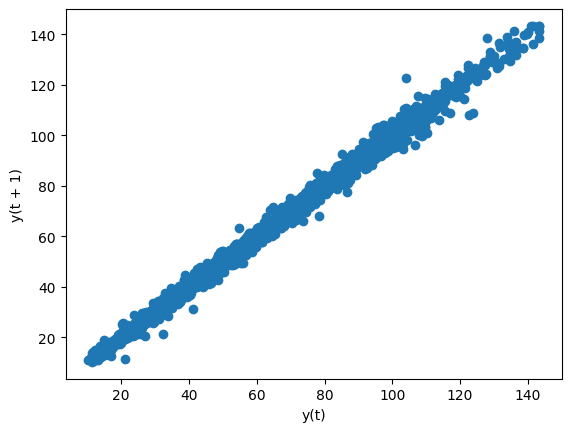

In [ ]:
lag_plot(oil.ClosingValue)

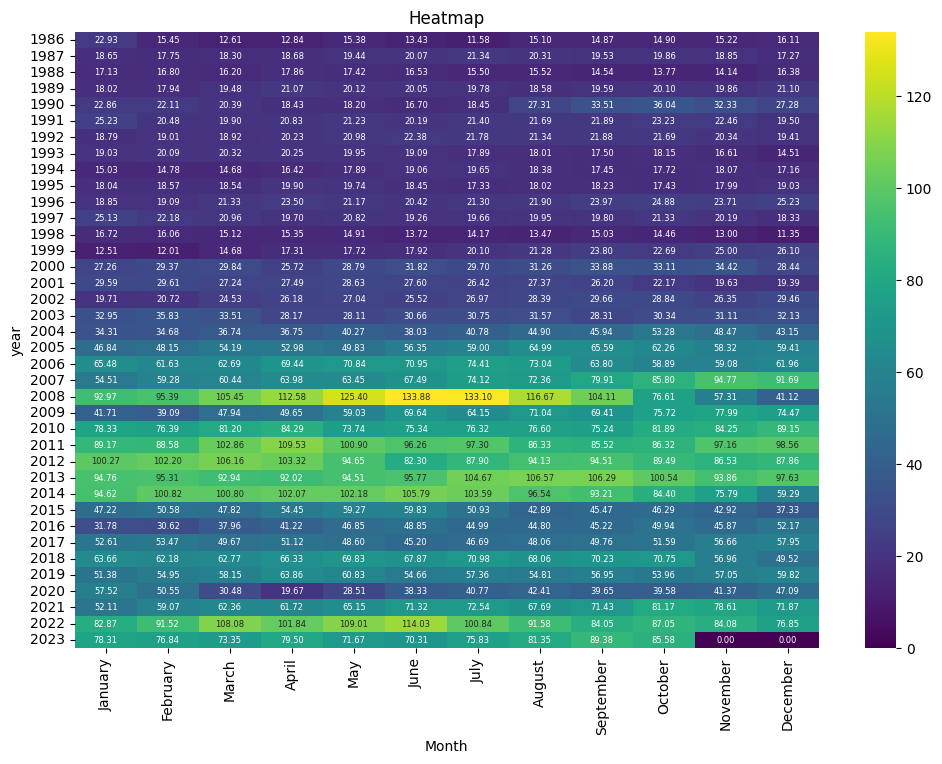

In [ ]:
#Heatmap

plt.figure(figsize=(12,8),)
sns.heatmap(oil_pivot,annot=True,fmt=".2f",cmap="viridis",annot_kws={"fontsize":6,"rotation":0,"ha":"center","va":'center'})
plt.title("Heatmap")
plt.show()

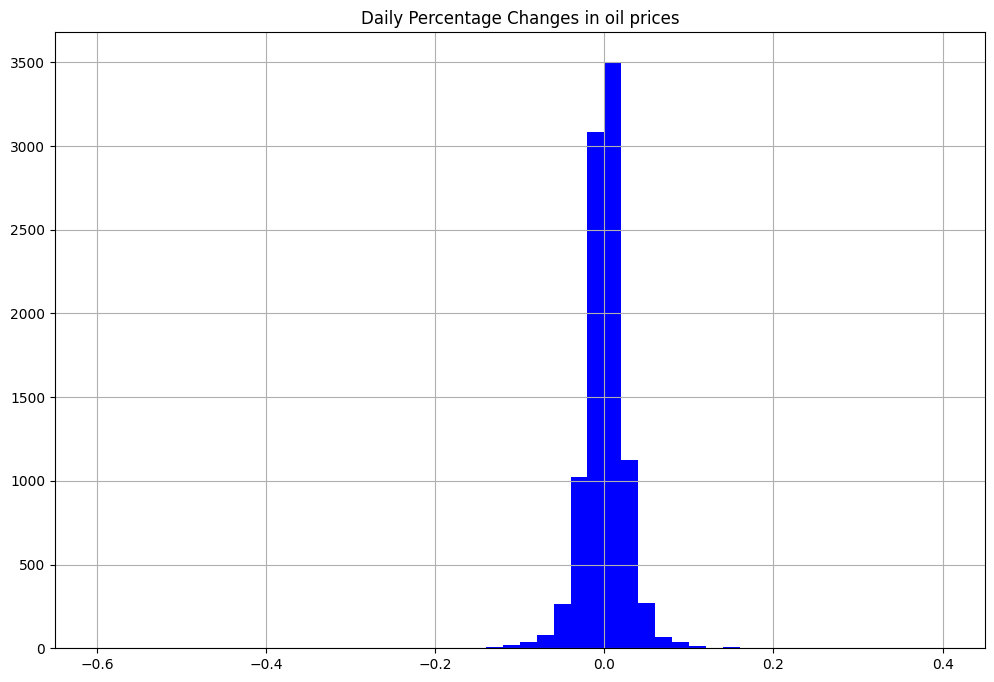

In [ ]:
oil_new_pct = oil_new.ClosingValue.pct_change()
plt.figure(figsize=(12,8))
oil_new_pct.hist(color="blue",bins=50,range=(-0.1,-0.1))
plt.title("Daily Percentage Changes in oil prices")
plt.show()

In [ ]:
oil_new["Pct_Change"]=oil_new_pct

In [ ]:
oil_new.head()

Date  ClosingValue    Month  year  Week  Pct_Change
0 1986-01-02         25.56  January  1986     1         NaN
1 1986-01-03         26.00  January  1986     1    0.017214
2 1986-01-06         26.53  January  1986     2    0.020385
3 1986-01-07         25.85  January  1986     2   -0.025631
4 1986-01-08         25.87  January  1986     2    0.000774

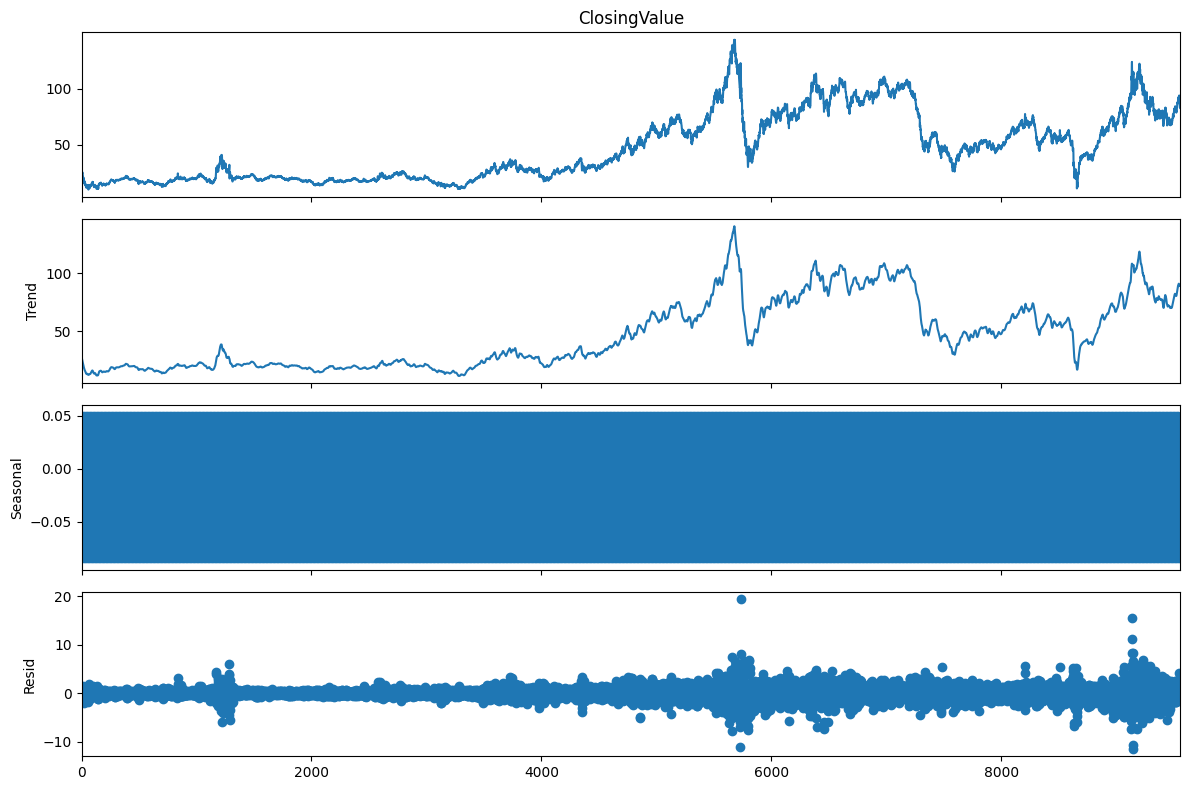

In [ ]:
decompose_ts_add = seasonal_decompose(oil.ClosingValue, period=12)
with plt.rc_context():
  plt.rc("figure", figsize=(12,8))
  decompose_ts_add.plot()

In [ ]:
#MAX&MIN
oil_new.ClosingValue.max(),oil_new.ClosingValue.idxmax()


(143.315, 5677)

In [ ]:
oil_new.ClosingValue.min(),oil_new.ClosingValue.idxmin()

(10.25, 60)

In [ ]:
oil_new.iloc[[5677,60],[0,1]]

Date  ClosingValue
5677 2008-07-02       143.315
60   1986-03-31        10.250

In [ ]:
oil_new.set_index("Date",inplace=True,drop=True)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

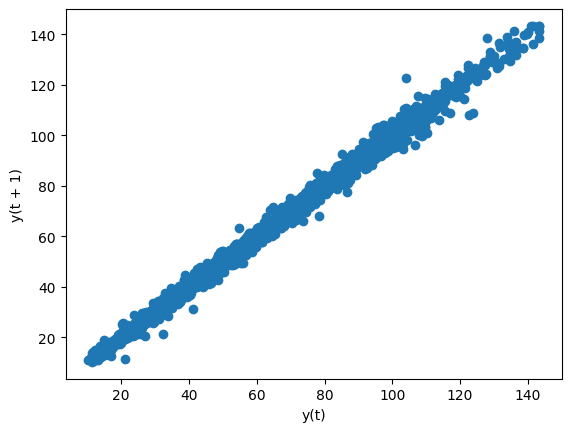

In [ ]:
lag_plot(oil_new.ClosingValue)

model building

In [ ]:
oil.set_index("Date",inplace=True,drop=True)

In [ ]:
oil.reset_index(inplace=True)
oil["t"]=1
for i, row in oil.iterrows():
  oil["t"].iloc[i]= i+1

In [ ]:
oil["t_sq"] = (oil.t)**2

In [ ]:
oil["log_ClosingValue"] = np.log(oil.ClosingValue)

In [ ]:
oil["sqrt_ClosingValue"] = np.sqrt(oil.ClosingValue)

In [ ]:
monthdf =pd.DataFrame()
monthdf["Month"] = oil.Date.dt.strftime("%b")
Months = pd.get_dummies(monthdf["Month"])
Months = Months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
oil = pd.concat([oil,Months],axis=1)


In [ ]:
oil.head()

Date  ClosingValue  t  t_sq  log_ClosingValue  sqrt_ClosingValue  Jan  \
0 1986-01-02         25.56  1     1          3.241029           5.055690    1   
1 1986-01-03         26.00  2     4          3.258097           5.099020    1   
2 1986-01-06         26.53  3     9          3.278276           5.150728    1   
3 1986-01-07         25.85  4    16          3.252311           5.084290    1   
4 1986-01-08         25.87  5    25          3.253084           5.086256    1   

   Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  
0    0    0    0    0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0    0    0    0    0  
4    0    0    0    0    0    0    0    0    0    0    0

In [ ]:
Train = oil.head(11034)
Test = oil.tail(2758)

In [ ]:
#Linear Model
import statsmodels.formula.api as smf
linear_model = smf.ols('ClosingValue~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.round(np.sqrt(np.mean((np.array(pred_linear)-np.array(Test['ClosingValue']))**2)),2)
print('RSME : ' , rmse_linear)

RSME :  24.2


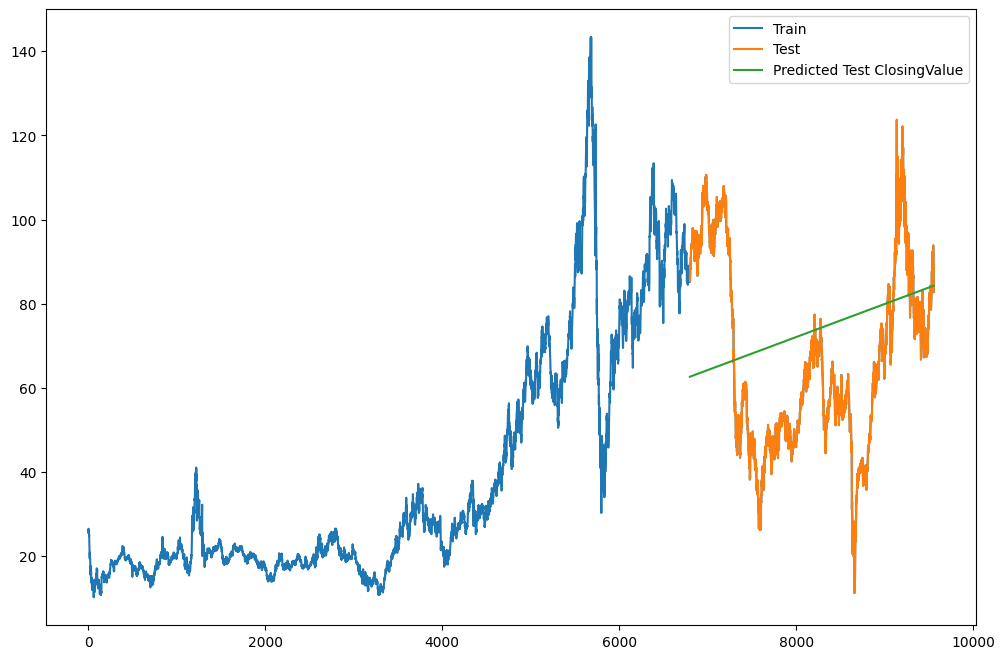

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(Train.ClosingValue,label = "Train")
plt.plot(Test.ClosingValue,label = "Test")
plt.plot(pred_linear,label="Predicted Test ClosingValue")
plt.legend()
plt.show()

In [ ]:
#EXPONENTIAL
Exp = smf.ols('log_ClosingValue~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.round(np.sqrt(np.mean((np.array(pred_Exp)-np.array(Test["ClosingValue"]))**2)),2)
rmse_Exp

66.35

In [ ]:
#QUADRATIC
Quad = smf.ols('ClosingValue~t+t_sq',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_sq"]]))
rmse_Quad = np.round(np.sqrt(np.mean((np.array(pred_Quad)-np.array(Test['ClosingValue']))**2)),2)
rmse_Quad

23.13

In [ ]:
#sqrt model
sqrt_model = smf.ols('sqrt_ClosingValue~t',data=Train).fit()
pred_sqrt = pd.Series(sqrt_model.predict(pd.DataFrame(Test["t"])))
rmse_sqrt = np.round(np.sqrt(np.mean((np.array(pred_sqrt)-np.array(Test['ClosingValue']))**2)),2)
rmse_sqrt

62.36

In [ ]:
#ADDITIVE SEASONALITY
add_sea = smf.ols('ClosingValue~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec', data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['ClosingValue'])-np.array(pred_add_sea))**2))
rmse_add_sea

29.723280213222736

In [ ]:
#ADDITIVE SEASONALITY QUADRATIC
add_sea_quad = smf.ols('ClosingValue~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec', data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_quad.predict(Test[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['ClosingValue'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

29.723280213222736

In [ ]:
#Multiplicative Additive Seasonality

Mul_Add_sea = smf.ols('ClosingValue~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['ClosingValue'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

7.469647825271977e+20

Data driven techniques

In [ ]:
oil = oil.iloc[:,[0,1]]
oil.set_index("Date",inplace=True,drop=True)
oil.head()

ClosingValue
Date                    
1986-01-02         25.56
1986-01-03         26.00
1986-01-06         26.53
1986-01-07         25.85
1986-01-08         25.87

In [ ]:
Train = oil.head(11034)
Test = oil.tail(2758)

In [ ]:
#ses
ses_model = SimpleExpSmoothing(Train).fit(smoothing_level=0.8,optimized=True)
test_pred_ses = ses_model.predict(start=Test.index[0],end=Test.index[-1])
test_rmse_ses = np.sqrt(mean_squared_error(test_pred_ses,Test))
test_rmse_ses

1.5816091040501048

In [ ]:
#Holts double exponential model
dexp_model = Holt(Train).fit(smoothing_level=0.8,smoothing_trend=0.9,optimized=True)
test_pred_dexp = dexp_model.predict(start=Test.index[0],end=Test.index[-1])
test_rmse_dexp = np.sqrt(mean_squared_error(test_pred_dexp,Test))
test_rmse_dexp

1.9289476439088797

Holts winter exponential smoothing with additive seasonality and additive trend

In [ ]:
hwe_model_add_add = ExponentialSmoothing(Train,seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
pred_rmse_add_add = np.sqrt(mean_squared_error(pred_hwe_add_add,Test))
pred_rmse_add_add

1.5567996720900552

In [ ]:
dftest = adfuller(oil,autolag="AIC")
dfoutput=pd.Series(dftest[0:4],index=["Test Statistic","p-value","#Lags Used","No.of Observations Used"])
dfoutput

Test Statistic               -2.064878
p-value                       0.258870
#Lags Used                   20.000000
No.of Observations Used    9536.000000
dtype: float64

In [ ]:
print("Results of Dickey-Fuller Test")
dftest = adfuller(oil_new["ClosingValue"])
dfoutput = pd.Series(dftest[0:4],index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
for key, value in dftest[4].items():
  dfoutput["Critical Value (%s)" %key] = value
  print(dfoutput)

Results of Dickey-Fuller Test
Test Statistic                   -2.064878
p-value                           0.258870
#Lags Used                       20.000000
Number of Observations Used    9536.000000
Critical Value (1%)              -3.431036
dtype: float64
Test Statistic                   -2.064878
p-value                           0.258870
#Lags Used                       20.000000
Number of Observations Used    9536.000000
Critical Value (1%)              -3.431036
Critical Value (5%)              -2.861843
dtype: float64
Test Statistic                   -2.064878
p-value                           0.258870
#Lags Used                       20.000000
Number of Observations Used    9536.000000
Critical Value (1%)              -3.431036
Critical Value (5%)              -2.861843
Critical Value (10%)             -2.566931
dtype: float64


In [ ]:
if dfoutput[1] <= 0.05:
  print("Data is stationary")
else:
    print("Data is non-stationary")


Data is non-stationary


In [ ]:
diff = oil.copy()
diff["ClosingValue"] = diff["ClosingValue"]-diff["ClosingValue"].shift()
dftest = adfuller(diff.dropna(),autolag="AIC")
dfoutput = pd.Series(dftest[0:4],index=["Test Statistics","p-value","#Lags USed","Number of Observations Used"])
dfoutput

Test Statistics               -1.306332e+01
p-value                        2.026169e-24
#Lags USed                     3.800000e+01
Number of Observations Used    9.517000e+03
dtype: float64

In [ ]:
diff.dropna(inplace=True)

In [ ]:
diff.head()

ClosingValue
Date                    
1986-01-03          0.44
1986-01-06          0.53
1986-01-07         -0.68
1986-01-08          0.02
1986-01-09          0.16

In [ ]:
if dfoutput[1] <= 0.05:
  print("Data is stationary")
else:
    print("Data is non-stationary")

Data is stationary


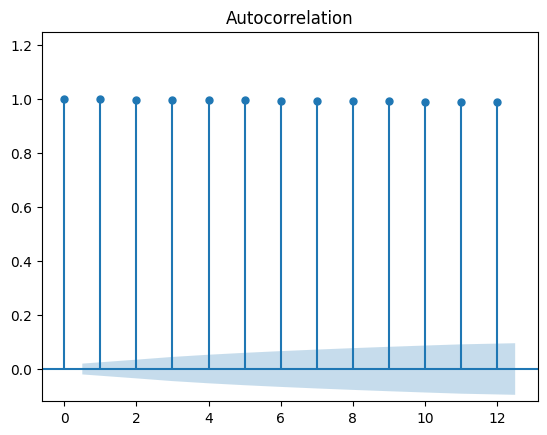

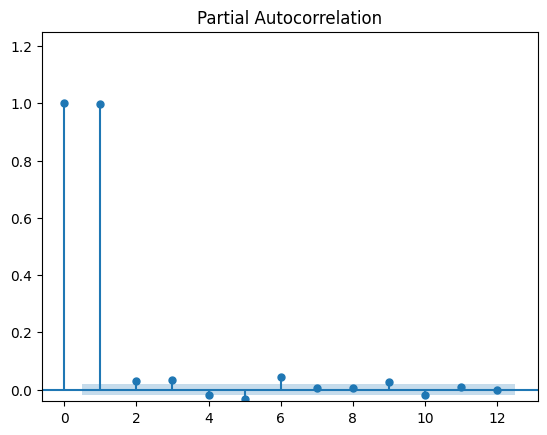

In [ ]:
tsa_plots.plot_acf(oil_new.ClosingValue,lags=12, auto_ylims=True)
tsa_plots.plot_pacf(oil_new.ClosingValue,lags=12,auto_ylims=True)
plt.show()

In [ ]:
Train = oil.head(round(oil.shape[0]*.8))
Test = oil.tail(oil.shape[0]-round(oil.shape[0]*.8))

In [ ]:
#SARIMA
model = SARIMAX(Train,order = (1,0,0),seasonal_order = (2,1,0,12))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       ClosingValue   No. Observations:                 7646
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood              -12883.067
Date:                            Sun, 05 Nov 2023   AIC                          25774.134
Time:                                    04:42:30   BIC                          25801.895
Sample:                                         0   HQIC                         25783.658
                                           - 7646                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9631      0.002    639.964      0.000       0.960       0.966
ar.S.L12      -0.6378      0.005   -124.012      0.000      -0.648      -0.628
ar.S.L24      -0.3232      0.005    -62.564      0.000      -0.333      -0.313
sigma2         1.7097      0.009    181.494      0.000       1.691       1.728
===================================================================================
Ljung-Box (L1) (Q):                  19.03   Jarque-Bera (JB):             76601.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.48   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start = len(Train)
end = len(Train)+len(Test)-1

In [ ]:
prediction = result.predict(start,end,typ="levels").rename("Prediction")
test_rmse_sarimax = np.sqrt(mean_squared_error(Test,prediction))
test_rmse_sarimax

24.696583331693923

In [ ]:
#LSTM MODEL
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from keras.models import load_model

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [ ]:
def prep_data(series_data, n_features):
  X, y = [], []
  for i in range(len(series_data)):
    end_ix = i + n_features
    if end_ix > len(series_data)-1:
     break
    seq_x,seq_y = series_data[i:end_ix], series_data[end_ix]
    X.append(seq_x)
    y.append(seq_y)
    return np.array(X),np.array(y)

In [ ]:
#input sequence
data = np.array(oil.ClosingValue)
n_features = 5
X, y = prep_data(data, n_features)
print(X)
print(y)

[[25.56 26.   26.53 25.85 25.87]]
[26.03]


In [ ]:
n_features = 1
X = X.reshape((X.shape[0],X.shape[1], n_features))

In [ ]:
X_train = X[:11030]
X_test = X[11030:]
y_train = y[:11030]
y_test = y[11030:]

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units=60, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.1))
regressor.add(LSTM(units=60, return_sequences=True))
regressor.add(Dropout(0.1))
regressor.add(LSTM(units=60))
regressor.add(Dropout(0.1))
regressor.add(Dense(units=1))
regressor.compile(optimizer="adam", loss="mean_squared_error")
regressor.fit(X_train, y_train, epochs=20, batch_size=20)

Epoch 1/20
1/1 [==============================] - 6s 6s/step - loss: 673.4472
Epoch 2/20
1/1 [==============================] - 0s 19ms/step - loss: 668.0109
Epoch 3/20
1/1 [==============================] - 0s 17ms/step - loss: 660.0063
Epoch 4/20
1/1 [==============================] - 0s 18ms/step - loss: 652.4662
Epoch 5/20
1/1 [==============================] - 0s 24ms/step - loss: 655.4547
Epoch 6/20
1/1 [==============================] - 0s 21ms/step - loss: 641.8802
Epoch 7/20
1/1 [==============================] - 0s 19ms/step - loss: 636.9099
Epoch 8/20
1/1 [==============================] - 0s 20ms/step - loss: 624.0472
Epoch 9/20
1/1 [==============================] - 0s 18ms/step - loss: 617.1577
Epoch 10/20
1/1 [==============================] - 0s 30ms/step - loss: 606.4667
Epoch 11/20
1/1 [==============================] - 0s 31ms/step - loss: 598.4703
Epoch 12/20
1/1 [==============================] - 0s 18ms/step - loss: 586.5164
Epoch 13/20
1/1 [======================

In [ ]:
#comparing
data = {"MODEL":pd.Series(["Linear","Exp","Quad","sqr","Add Sea","Add Sea Quad","SimpExpSmoo","DoubleES","HoltsW","SARIMAX"]),"RMSE":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_sqrt,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_add_sea,test_rmse_ses,test_rmse_dexp,pred_rmse_add_add,test_rmse_sarimax])}
RMSE_Table = pd.DataFrame(data)
RMSE_Table.sort_values(["RMSE"],ascending=True)

MODEL          RMSE
9        SARIMAX  1.556800e+00
7       DoubleES  1.581609e+00
8         HoltsW  1.928948e+00
2           Quad  2.313000e+01
0         Linear  2.420000e+01
10           NaN  2.469658e+01
4        Add Sea  2.972328e+01
5   Add Sea Quad  2.972328e+01
3            sqr  6.236000e+01
1            Exp  6.635000e+01
6    SimpExpSmoo  7.469648e+20

In [ ]:
#Forecast using DEXP Model
dexp_model = Holt(oil).fit(smoothing_level=0.8,smoothing_trend=0.9,optimized=True)
f_dexp = dexp_model.forecast(365)


In [ ]:
#Forecast using SARIMAX model
model = SARIMAX(oil,order=(1,0,0),seasonal_order=(2,1,0,12))
result=model.fit()
forecast = result.forecast(365)
forecast

9557    83.384645
9558    83.712590
9559    83.240683
9560    83.346429
9561    84.725394
          ...    
9917    83.763132
9918    84.247363
9919    83.850271
9920    84.375048
9921    86.176886
Name: predicted_mean, Length: 365, dtype: float64

In [ ]:
!pip install prophet

In [ ]:
!pip install streamlit

In [ ]:
from prophet import Prophet
from prophet.plot import plot_components_plotly,plot_plotly

In [ ]:
oil = pd.read_excel("Crude_Oil_Prices_Daily.xlsx")


In [ ]:
oil.rename(columns={"Closing Value":"ClosingValue"},inplace=True)

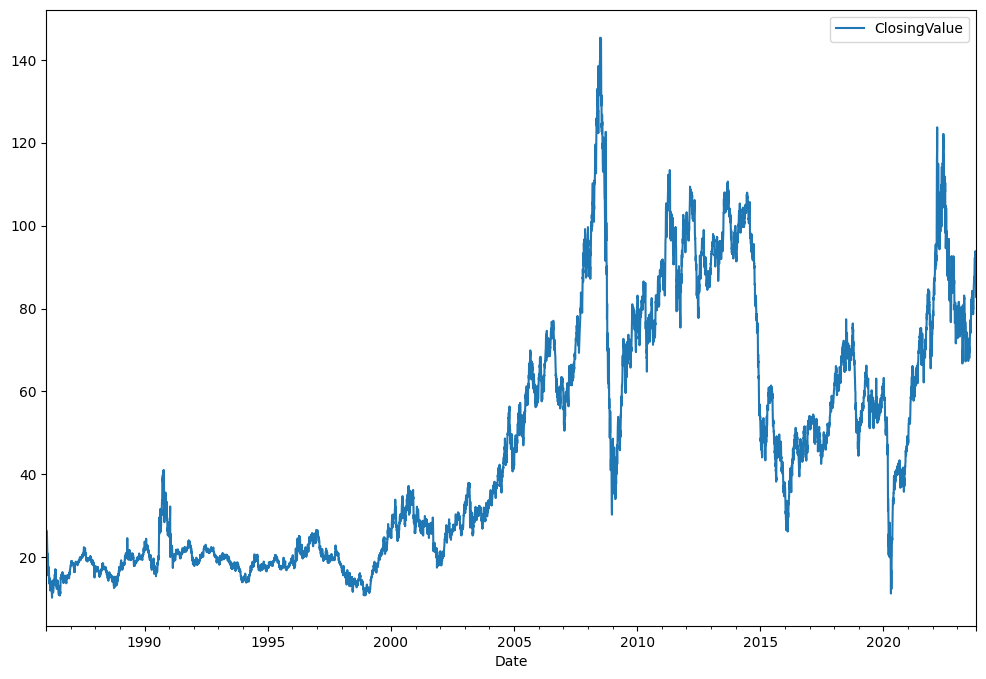

In [ ]:
oil.set_index("Date",inplace=True,drop=True)
oil = oil.resample("D").mean()
oil = oil.interpolate(method="linear")
oil.plot(figsize=(12,8))
plt.show()

In [ ]:
#FB Prophet method
oil.reset_index(inplace=True)
oil.columns = ["ds","y"]

In [ ]:
train = oil.iloc[:len(oil)-365]
test = oil.iloc[len(oil)-365:]

In [ ]:
m = Prophet(interval_width=.97)
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn18y1bpy/01loktj9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn18y1bpy/z1359xst.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34734', 'data', 'file=/tmp/tmpn18y1bpy/01loktj9.json', 'init=/tmp/tmpn18y1bpy/z1359xst.json', 'output', 'file=/tmp/tmpn18y1bpy/prophet_modelfz8yjss1/prophet_model-20231105044308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:43:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:43:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)


In [ ]:
forecast.tail(5)

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
13787 2023-10-02  79.648820   52.882544  106.635141    58.740732   103.358180   
13788 2023-10-03  79.661226   53.722443  109.754375    58.694268   103.441920   
13789 2023-10-04  79.673633   51.710646  109.440017    58.627472   103.525660   
13790 2023-10-05  79.686039   54.649536  109.422169    58.544119   103.608736   
13791 2023-10-06  79.698445   53.834503  110.835816    58.460765   103.691620   

       additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
13787        0.702351              0.702351              0.702351 -0.007516   
13788        0.673459              0.673459              0.673459 -0.029907   
13789        0.680409              0.680409              0.680409 -0.015004   
13790        0.689979              0.689979              0.689979  0.004411   
13791        0.699105              0.699105              0.699105  0.025704   

       weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
13787     -0.007516     -0.007516  0.709867      0.709867      0.709867   
13788     -0.029907     -0.029907  0.703366      0.703366      0.703366   
13789     -0.015004     -0.015004  0.695413      0.695413      0.695413   
13790      0.004411      0.004411  0.685568      0.685568      0.685568   
13791      0.025704      0.025704  0.673402      0.673402      0.673402   

       multiplicative_terms  multiplicative_terms_lower  \
13787                   0.0                         0.0   
13788                   0.0                         0.0   
13789                   0.0                         0.0   
13790                   0.0                         0.0   
13791                   0.0                         0.0   

       multiplicative_terms_upper       yhat  
13787                         0.0  80.351171  
13788                         0.0  80.334685  
13789                         0.0  80.354042  
13790                         0.0  80.376018  
13791                         0.0  80.397550

In [ ]:
predictions = forecast.iloc[-365:]["yhat"]

In [ ]:
round(rmse(predictions,test.y),2)

7.14

In [ ]:
plot_plotly(m,forecast)

In [ ]:
plot_components_plotly(m,forecast)

In [ ]:
#final model
m = Prophet()
m.fit(oil)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn18y1bpy/m46egrzg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn18y1bpy/42gbw_y6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38912', 'data', 'file=/tmp/tmpn18y1bpy/m46egrzg.json', 'init=/tmp/tmpn18y1bpy/42gbw_y6.json', 'output', 'file=/tmp/tmpn18y1bpy/prophet_modeldo2acjqq/prophet_model-20231105044344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:43:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:43:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
import pickle
pickle_out = open("prophet.pkl",mode = "wb")
pickle.dump(m,pickle_out)
pickle_out.close()

In [ ]:
%%writefile crudeoilprices.py

import streamlit as st
import pickle
import prophet
from prophet import Prophet


pickle_in = open("prophet.pkl","rb")
model = pickle.load(pickle_in)

@st. cache_data()
def prediction(n_years):
  future = model.make_future_dataframe(periods = n_years*365)
  forecast = model.predict(future)
  data = forecast.iloc[n_years*(-365):]
  return data

def main():
  html_temp="""<div style = "background-color:gray;padding:11px"> <h1 style = "color:blue;text-align:center;">Crude Oil Prices Forecast</h1>
  </div>"""
  st.markdown(html_temp,unsafe_allow_html=True)
  n_years = st.slider("Select the number of years of forecast: ",1,3)
  if st.button("Forecast"):
    result = prediction(n_years)
    st.subheader("Forecast Data:")
    st.write(result[["ds","yhat"]])
    st.subheader("Forecast Plot:")
    fig = plot_plotly(model,result)
    st.plotly_chart(Fig)

if __name__ =="__main__":
  main()


Writing crudeoilprices.py
